In [25]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
segments = gpd.read_file('segmentacion_general_san_martin.geojson')
segments.rename(columns={'name':'area', 'description':'region'},inplace=True)

props = pd.read_csv('https://raw.githubusercontent.com/nvrancovich/san_martin_propiedades_geodatos/main/features_propiedades_4371.csv')
props = gpd.GeoDataFrame(props, geometry=gpd.points_from_xy(props.longitude, props.latitude))
props = props.set_crs('EPSG:4326')


df = props.sjoin(segments, how='inner')
df.drop(columns = ['Unnamed: 0','index_right','region','geometry'], inplace=True)
df['price/m2'] = df.price_USD / df.covered_surface_m2

segments_avg = df.groupby('area').mean()[['covered_surface_m2', 'antiquity', 'price_USD', 'price/m2']].reset_index(level=0)
df.drop(labels='price/m2', axis=1, inplace=True)
segments_avg = segments_avg[['area','price/m2']]
segments_avg = segments_avg.set_index('area')

df = df.join(segments_avg, how='inner',on='area')

df['bathrooms'] = df['bathrooms'].fillna(1)
df.dropna(subset=['bedrooms'], axis=0, inplace=True)
df.dropna(subset=['latitude'], axis=0, inplace=True)
df.dropna(subset=['covered_surface_m2'], axis=0, inplace=True)
df.dropna(subset=['price_USD'], axis=0, inplace=True)
df = df[['price_USD','type','covered_surface_m2','bedrooms','price/m2','bathrooms','latitude','longitude']]
df.reset_index(drop=True, inplace=True)

In [50]:
df

,price_USD,type,covered_surface_m2,bedrooms,price/m2,bathrooms,latitude,longitude
0,122000.0,departamento,53.0,1.0,2217.485589,2.0,-34.545467,-58.552177
1,150000.0,departamento,85.0,2.0,2217.485589,2.0,-34.548748,-58.556840
2,289100.0,departamento,128.0,3.0,2217.485589,2.0,-34.546143,-58.551445
3,200000.0,departamento,94.0,2.0,2217.485589,2.0,-34.547916,-58.555870
4,200000.0,departamento,98.0,2.0,2217.485589,2.0,-34.547894,-58.557316
...,...,...,...,...,...,...,...,...
3334,150000.0,casa,106.0,3.0,1206.072115,2.0,-34.585290,-58.557682
3335,220000.0,casa,230.0,4.0,1206.072115,2.0,-34.578120,-58.550300
3336,105000.0,casa,90.0,3.0,1206.072115,1.0,-34.583900,-58.543210
3337,100000.0,casa,94.0,3.0,1206.072115,2.0,-34.583400,-58.542070


In [4]:
df = pd.get_dummies(df, columns=['type'])

In [5]:
df.corr().price_USD

price_USD             1.000000
covered_surface_m2    0.771365
bedrooms              0.573037
price/m2              0.193148
bathrooms             0.647871
latitude              0.026302
longitude             0.034955
type_casa             0.453606
type_departamento    -0.295035
type_ph              -0.174588
Name: price_USD, dtype: float64

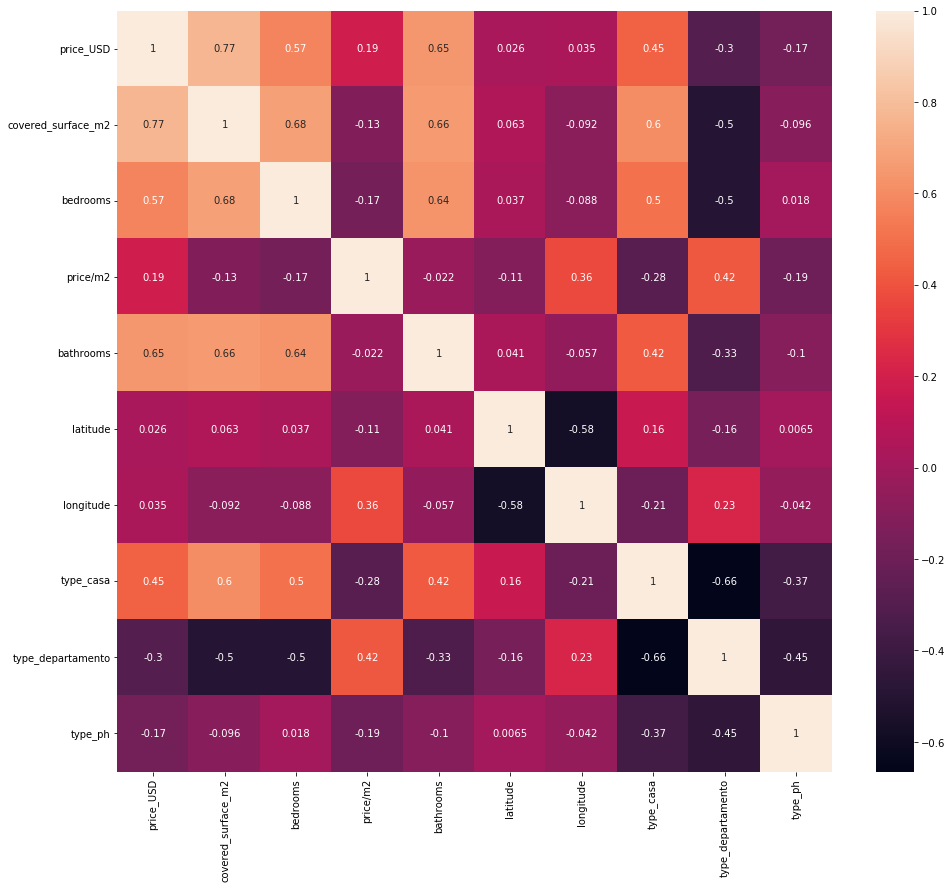

In [6]:
plt.figure(figsize=(16,14))
sns.heatmap(df.corr(), annot=True)

In [7]:
df = df[df.corr().columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3339 entries, 1 to 4347
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_USD           3339 non-null   float64
 1   covered_surface_m2  3339 non-null   float64
 2   bedrooms            3339 non-null   float64
 3   price/m2            3339 non-null   float64
 4   bathrooms           3339 non-null   float64
 5   latitude            3339 non-null   float64
 6   longitude           3339 non-null   float64
 7   type_casa           3339 non-null   uint8  
 8   type_departamento   3339 non-null   uint8  
 9   type_ph             3339 non-null   uint8  
dtypes: float64(7), uint8(3)
memory usage: 218.5 KB


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from p.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
import numpy as np

In [10]:
def split_data (df):
    X = df.drop('price_USD', axis=1)
    y = df.loc[:, ['price_USD']]
    return train_test_split(X, y, test_size=0.3, random_state=3)

In [11]:
def xgboost_regression (df):
    X_train, X_test, y_train, y_test = split_data(df)

    xgboost_reg = XGBRegressor(random_state=10,gamma= 24.47 ,learning_rate=0.1235,max_depth=10,
                      n_estimators=570,subsample=0.74,reg_lambda=0.8)

    y_pred_xgb_train = cross_val_predict(xgboost_reg, X_train, y_train, cv=10)
    RMSE_xgboost_train = np.sqrt(mean_squared_error(y_train, y_pred_xgb_train))
    R2_xgboost_train = r2_score(y_train, y_pred_xgb_train)
    MAE_xgboost_train = mean_absolute_error(y_train, y_pred_xgb_train)

    y_pred_xgb_test = cross_val_predict(xgboost_reg, X_test, y_test, cv=10)
    RMSE_xgboost_test = np.sqrt(mean_squared_error(y_test, y_pred_xgb_test))
    R2_xgboost_test = r2_score(y_test, y_pred_xgb_test)
    MAE_xgboost_test = mean_absolute_error(y_test, y_pred_xgb_test)

    print('RMSE (train): ', RMSE_xgboost_train)
    print('RMSE (test): ', RMSE_xgboost_test)
    print('R2 Score (train): ', R2_xgboost_train)
    print('R2 Score (test): ', R2_xgboost_test)
    print('MAE (train): ', MAE_xgboost_train)
    print('MAE (test): ', MAE_xgboost_test)
    
    return xgboost_reg

In [18]:
xgboost_reg = xgboost_regression(df)

RMSE (train):  40341.14277683596
RMSE (test):  46174.417316649844
R2 Score (train):  0.760811110244693
R2 Score (test):  0.6806525410674027
MAE (train):  26144.67584727348
MAE (test):  28346.850412456337


In [21]:
X = df.drop('price_USD', axis=1)
y = df.loc[:, ['price_USD']]
xgboost_reg.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=24.47, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1235, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=570, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=10,
             reg_alpha=0, reg_lambda=0.8, ...)

In [22]:
xgboost_reg.save_model('xgboost_reg.json')